Let's try to use a neural network as a classification estimator.  We will use awesome [caffe](http://caffe.berkeleyvision.org) framework.

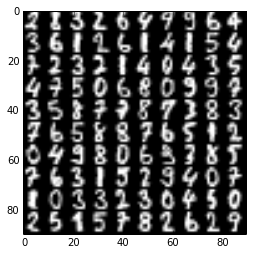

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn import datasets

digits = datasets.load_digits()

# split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split( digits.data, 
                                                    digits.target,
                                                    test_size=0.33 )

# courtesy caffe devs - usefull for visualisation of tilled images
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data, cmap = plt.get_cmap('gray') )
    
vis_square( X_train[ 0:100 ].reshape(100,8,8) )

We're going to use one convolutional layer.  To avoid config-fu with caffe, the data will go into LMDB store.  But 1st, let's cleanup the environment to avoid costly debugging.

In [2]:
rm -r digits_train_lmdb digits_test_lmdb

Caffe uses fairly simple kev / value format.  The code below performs conversion from sklearn dataset into LMDB.

In [3]:
import lmdb
import sys
sys.path.append( './caffe/python' )
import caffe

env = lmdb.open( 'digits_train_lmdb', map_size=1000000000L )

k = 0
for i in range( X_train.shape[0] ):
    x_in = X_train[ i ].reshape( (8,8) ).astype( np.uint8 )
    
    # add original digit
    datum = caffe.proto.caffe_pb2.Datum()
    datum.channels = 1
    datum.height = 8
    datum.width = 8
    datum.data = x_in.tostring()
    datum.label = int( y_train[i] )

    str_id = '{:08}'.format( k )
    k += 1
    with env.begin( write=True ) as txn:
        txn.put( str_id.encode('ascii'), datum.SerializeToString() )

print( env.stat() )
env.close()

env = lmdb.open( 'digits_test_lmdb', map_size=1000000000L )
k = 0
for i in range( X_test.shape[0] ):
    x_in = X_test[ i ].reshape( (8,8) ).astype( np.uint8 )
    
    # add original digit
    datum = caffe.proto.caffe_pb2.Datum()
    datum.channels = 1
    datum.height = 8
    datum.width = 8
    datum.data = x_in.tostring()
    datum.label = int( y_test[i] )
    
    str_id = '{:08}'.format( k )
    k += 1
    with env.begin( write=True ) as txn:
        txn.put( str_id.encode('ascii'), datum.SerializeToString() )

print( env.stat() )
env.close()

{'branch_pages': 1L, 'leaf_pages': 28L, 'overflow_pages': 0L, 'psize': 4096L, 'depth': 2L, 'entries': 1203L}
{'branch_pages': 1L, 'leaf_pages': 14L, 'overflow_pages': 0L, 'psize': 4096L, 'depth': 2L, 'entries': 594L}


We're going to define here solver parameters and network structure.  The original MNIST reference net included with caffe, had two convolutional layers.  Given the small size of the input picture (8x8), we're only going to use one convolutional layer.

In [4]:
solver_txt = """
# The train/test net protocol buffer definition
net: "digits_train_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# the batch is 64 images
test_iter: 100
# Carry out testing every 100 training iterations.
test_interval: 100
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.95
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 1000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "digits"
# solver mode: CPU or GPU
solver_mode: GPU

"""

open( 'digits_solver.prototxt', 'wt' ).write( solver_txt )

digits_train_test = """
name: "digits"
layer {
  name: "digits_data"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TRAIN
  }
  transform_param {
    scale: 0.0625
  }
  data_param {
    source: "digits_train_lmdb"
    batch_size: 100
    backend: LMDB
  }
}
layer {
  name: "digits_data"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TEST
  }
  transform_param {
    scale: 0.0625
  }
  data_param {
    source: "digits_test_lmdb"
    batch_size: 100
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  convolution_param {
    num_output: 50
    kernel_size: 3
    stride: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "ip1"
  type: "InnerProduct"
  bottom: "pool1"
  top: "ip1"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  inner_product_param {
    num_output: 500
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "ip1"
  top: "ip1"
}

layer {
  name: "ip2"
  type: "InnerProduct"
  bottom: "ip1"
  top: "ip2"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  inner_product_param {
    num_output: 10
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "accuracy"
  type: "Accuracy"
  bottom: "ip2"
  bottom: "label"
  top: "accuracy"
  include {
    phase: TEST
  }
}
layer {
  name: "loss"
  type: "SoftmaxWithLoss"
  bottom: "ip2"
  bottom: "label"
  top: "loss"
}
"""

open( 'digits_train_test.prototxt', 'wt' ).write( digits_train_test )

Let's start the training using GPU.

In [5]:
!./caffe/build/tools/caffe train -solver digits_solver.prototxt 2> digits_train.log

In [6]:
!python ./caffe/tools/extra/parse_log.py digits_train.log .

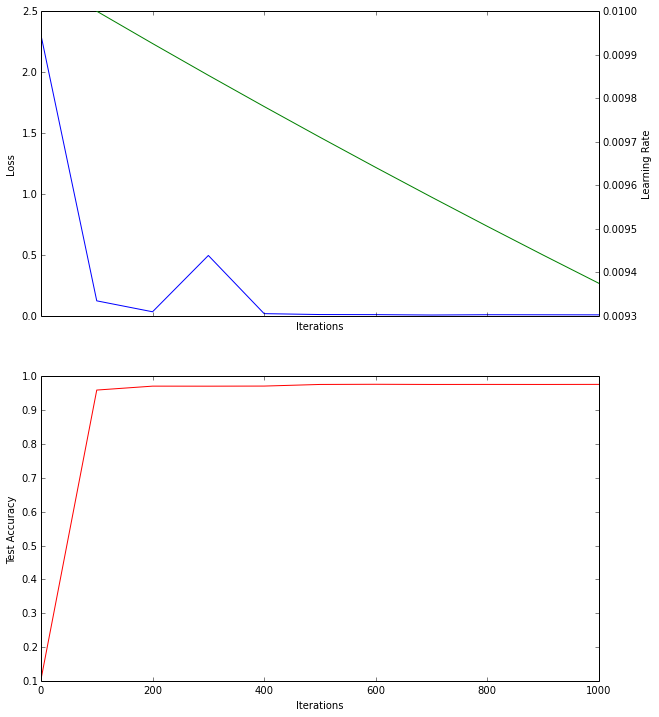

In [7]:
import pandas as pd

# columns: NumIters,Seconds,TrainingLoss,LearningRate
df_train = pd.read_csv( 'digits_train.log.train' )
# columns: NumIters,Seconds,TestAccuracy,TestLoss
df_test = pd.read_csv( 'digits_train.log.test' )

fig, (ax1, ax2) = plt.subplots( 2, sharex=True, figsize=(10, 12) )

ax1.plot( df_train.NumIters, df_train.TrainingLoss, 'b-' )

ax1.set_xlabel( 'Iterations' )
ax1.set_ylabel( 'Loss' )

ax3 = ax1.twinx()
ax3.plot( df_train.NumIters, df_train.LearningRate, 'g-' )
ax3.set_ylabel( 'Learning Rate' )

ax2.plot( df_test.NumIters, df_test.TestAccuracy, 'r-' )
ax2.set_xlabel( 'Iterations' )
ax2.set_ylabel( 'Test Accuracy' )

plt.show()

In [8]:
print( 'Final accuracy: {0}'.format( df_test.tail(1).TestAccuracy.iloc[0] ) )

Final accuracy: 0.9765
